# Initialisation de la session Spark

In [1]:
# spark.stop()

In [2]:
from pyspark.sql import SparkSession
import os
from pyspark.ml.evaluation import RegressionEvaluator

spark = (SparkSession.builder
    .appName("house_pricing_model")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.1")
    .config("spark.hadoop.fs.s3a.endpoint", "http://localhost:9000")
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin")
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin")
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    # Optimisations de performances
    .config("spark.dynamicAllocation.enabled", "true")
    .config("spark.executor.cores", str(max(1, os.cpu_count() - 1)))
    .config("spark.driver.memory", "16g")
    .config("spark.executor.memory", "12g")
    .config("spark.memory.fraction", "0.8")
    .config("spark.memory.storageFraction", "0.2")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .config("spark.sql.shuffle.partitions", str(os.cpu_count() * 2))
    .config("spark.default.parallelism", str(os.cpu_count() * 2))
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    # Configuration des logs
    .config("spark.driver.extraJavaOptions", "-Dlog4j.configuration=log4j.properties")
    .config("spark.executor.extraJavaOptions", "-Dlog4j.configuration=log4j.properties")
    .config("spark.sql.warnings.ignore", "true")
    .config("spark.log.level", "ERROR")
    .config("spark.driver.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=false")
    .getOrCreate())

bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
25/02/28 11:45:17 WARN Utils: Your hostname, Arthur resolves to a loopback address: 127.0.1.1; using 172.22.98.237 instead (on interface eth0)
25/02/28 11:45:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/arthur/.virtualenvs/investscan_data_platform/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/arthur/.ivy2/cache
The jars for the packages stored in: /home/arthur/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-59d5c09a-1c12-44e4-bd18-779a4fc91c96;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 146ms :: artifacts dl 6ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.901 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.1 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------

In [3]:
info_df = spark.read.option("multiline", "true").option("mode", "PERMISSIVE").json("s3a://ml-datasets/house_price_model/latest/info.json")
version = info_df.collect()[0]['redirect_to']

# Chemins des fichiers
base_path = f"s3a://ml-datasets/house_price_model/{version}/"

# Chargement des données

In [4]:
# Chargement des DataFrames
df_full = spark.read.parquet(base_path + "full_dataset.parquet")
df_train = spark.read.parquet(base_path + "train.parquet")
df_validation = spark.read.parquet(base_path + "validation.parquet")
df_test = spark.read.parquet(base_path + "test.parquet")

# Affichage rapide
df_full.printSchema()
print("Nombre de lignes dans le dataset train :", df_train.count())

root
 |-- annee_mutation: integer (nullable = true)
 |-- mois_mutation: integer (nullable = true)
 |-- valeur_fonciere: double (nullable = true)
 |-- code_postal: string (nullable = true)
 |-- surface_reelle_bati: double (nullable = true)
 |-- nombre_pieces_principales: integer (nullable = true)
 |-- surface_terrain: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- code_type_local: integer (nullable = true)
 |-- ratio_terrain_bati: double (nullable = true)
 |-- distance_mer_km: double (nullable = true)
 |-- proche_mer: integer (nullable = true)

Nombre de lignes dans le dataset train : 188999


# Prétraitement des données

In [5]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler

def target_encoding(df, categorical_col='code_postal', target_col='valeur_fonciere', smoothing=10):
    """
    Applique un target encoding sur une colonne catégorielle par rapport à la moyenne de la colonne cible.

    Paramètres:
    -----------
    df : DataFrame Spark
        Le DataFrame contenant les données
    categorical_col : str, optionnel (défaut='code_postal')
        Le nom de la colonne catégorielle à encoder
    target_col : str, optionnel (défaut='valeur_fonciere')
        Le nom de la colonne cible dont on calcule la moyenne
    smoothing : int, optionnel (défaut=10)
        Facteur de lissage pour éviter l'overfitting sur les catégories peu fréquentes

    Return :
    ---------
    DataFrame : DataFrame Spark avec une nouvelle colonne contenant l'encodage
    """
    # Calculer la moyenne globale de la colonne cible
    global_avg = df.select(F.avg(target_col)).collect()[0][0]

    # Calculer les statistiques par catégorie
    category_stats = df.groupBy(categorical_col).agg(
        F.avg(target_col).alias('category_avg'),
        F.count('*').alias('category_count')
    )

    # Appliquer le lissage bayésien (smoothing)
    category_stats = category_stats.withColumn(
        'encoded_value',
        (F.col('category_avg') * F.col('category_count') + global_avg * smoothing) /
        (F.col('category_count') + smoothing)
    )

    # Joindre l'encodage au DataFrame original
    encoded_col_name = f"{categorical_col}_encoded"
    encoded_df = df.join(
        category_stats.select(categorical_col, 'encoded_value'),
        on=categorical_col,
        how='left'
    ).withColumnRenamed('encoded_value', encoded_col_name)

    # Gérer les valeurs manquantes avec la moyenne globale
    encoded_df = encoded_df.fillna({encoded_col_name: global_avg})

    return encoded_df

In [6]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import SQLTransformer

def prepare_features_with_encoding(df, target_column='valeur_fonciere',
                                         categorical_cols=['code_postal'],
                                         exclude_columns=None):
    """
    Crée un pipeline de prétraitement avec target encoding pour les colonnes catégorielles.

    Paramètres:
    -----------
    df : DataFrame Spark
        Le DataFrame d'entraînement contenant les données
    target_column : str, optionnel (défaut='valeur_fonciere')
        Le nom de la colonne cible à prédire
    categorical_cols : list, optionnel (défaut=['code_postal'])
        Liste des colonnes catégorielles à encoder
    exclude_columns : list, optionnel
        Liste des colonnes à exclure du vecteur de caractéristiques

    Retourne:
    ---------
    Tuple : (DataFrame transformé, PipelineModel de prétraitement)
    """
    # Initialiser la liste d'exclusion
    if exclude_columns is None:
        exclude_columns = []

    # Ajouter la colonne cible à la liste d'exclusion
    if target_column not in exclude_columns:
        exclude_columns.append(target_column)

    # Étapes du pipeline
    stages = []

    # Créer les transformations pour chaque colonne catégorielle
    # for cat_col in categorical_cols:
    #     # Calculer la moyenne globale et les statistiques par catégorie en utilisant SQLTransformer
    #     encoded_col = f"{cat_col}_encoded"
    #
    #     # Étape 1: Calculer les statistiques globales et par catégorie
    #     stats_calculator = SQLTransformer(
    #         statement=f"""
    #         WITH global_stats AS (
    #             SELECT AVG({target_column}) as global_avg FROM __THIS__
    #         ),
    #         category_stats AS (
    #             SELECT
    #                 {cat_col},
    #                 AVG({target_column}) as category_avg,
    #                 COUNT(*) as category_count
    #             FROM __THIS__
    #             GROUP BY {cat_col}
    #         )
    #         SELECT
    #             t.*,
    #             COALESCE(
    #                 (cs.category_avg * cs.category_count + gs.global_avg * 10) / (cs.category_count + 10),
    #                 gs.global_avg
    #             ) as {encoded_col}
    #         FROM __THIS__ t
    #         CROSS JOIN global_stats gs
    #         LEFT JOIN category_stats cs ON t.{cat_col} = cs.{cat_col}
    #         """
    #     )
    #     stages.append(stats_calculator)

    # Identifier les colonnes numériques
    numeric_columns = [col for col, dtype in df.dtypes
                      if dtype in ['int', 'double', 'float']
                      and col not in exclude_columns]

    # Ajouter les colonnes encodées
    # encoded_columns = [f"{col}_encoded" for col in categorical_cols]

    # Toutes les colonnes à utiliser comme features
    # feature_columns = numeric_columns + encoded_columns
    feature_columns = numeric_columns
    print(f"Colonnes utilisées comme caractéristiques: {feature_columns}")

    # Ajouter l'étape d'assemblage des vecteurs
    assembler = VectorAssembler(
        inputCols=feature_columns,
        outputCol="features",
        handleInvalid="skip"
    )
    stages.append(assembler)

    # Créer et appliquer le pipeline
    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(df)

    # Transformer le DataFrame d'entraînement
    df_transformed = pipeline_model.transform(df).select("features", target_column)

    return df_transformed, pipeline_model

In [7]:
preprocessing_model = prepare_features_with_encoding(df_train)[1]

df_train_features = preprocessing_model.transform(df_train).select("features", "valeur_fonciere")
df_validation_features = preprocessing_model.transform(df_validation).select("features", "valeur_fonciere")
df_test_features = preprocessing_model.transform(df_test).select("features", "valeur_fonciere")

Colonnes utilisées comme caractéristiques: ['annee_mutation', 'mois_mutation', 'surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain', 'longitude', 'latitude', 'code_type_local', 'ratio_terrain_bati', 'distance_mer_km', 'proche_mer']


# Création Baseline

In [8]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
def create_baselines_from_raw_df(df_train, df_validation, df_test, target_column="valeur_fonciere"):
    """
    Crée plusieurs modèles baseline directement à partir des données brutes (non vectorisées)

    Paramètres:
    -----------
    df_train : DataFrame Spark
        DataFrame d'entraînement brut avec toutes les colonnes originales
    df_validation : DataFrame Spark
        DataFrame de validation brut avec toutes les colonnes originales
    df_test : DataFrame Spark
        DataFrame de test brut avec toutes les colonnes originales
    target_column : str
        Nom de la colonne cible à prédire

    Retourne:
    ---------
    dict : Dictionnaire des performances des différents modèles baseline
    """
    results = {}

    # Vérifier que les colonnes nécessaires existent
    required_cols = ["surface_reelle_bati", "code_postal", target_column, "nombre_pieces_principales"]
    for col in required_cols:
        if col not in df_train.columns:
            raise ValueError(f"La colonne '{col}' est requise mais n'est pas présente dans le DataFrame")

    print("Schéma du DataFrame d'entraînement:")
    df_train.printSchema()

    # 1. Baseline #1: Moyenne globale
    global_mean = df_train.select(F.mean(target_column).alias("prediction")).collect()[0][0]
    print(f"Moyenne globale des prix: {global_mean:.2f}")

    # Prédiction avec la moyenne globale
    global_mean_predictions = df_validation.withColumn("prediction", F.lit(global_mean))

    # Évaluation
    evaluator = RegressionEvaluator(
        labelCol=target_column,
        predictionCol="prediction",
        metricName="rmse"
    )

    rmse = evaluator.evaluate(global_mean_predictions)
    mae = evaluator.setMetricName("mae").evaluate(global_mean_predictions)
    r2 = evaluator.setMetricName("r2").evaluate(global_mean_predictions)

    results["moyenne_globale"] = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }

    print(f"Baseline Moyenne Globale: RMSE = {rmse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}")

    # 2. Baseline #2: Moyenne par code postal
    print("Calcul de la baseline par code postal...")
    postal_code_means = df_train.groupBy("code_postal").agg(
        F.mean(target_column).alias("postal_mean"),
        F.count("*").alias("count")
    )

    # Nombre de codes postaux uniques
    num_postal_codes = postal_code_means.count()
    print(f"Nombre de codes postaux uniques: {num_postal_codes}")

    # Joindre avec le dataset de validation
    postal_predictions = df_validation.join(
        postal_code_means,
        on="code_postal",
        how="left"
    )

    # Utiliser la moyenne globale pour les codes postaux non présents dans l'ensemble d'entraînement
    postal_predictions = postal_predictions.withColumn(
        "prediction",
        F.coalesce(F.col("postal_mean"), F.lit(global_mean))
    )

    # Évaluation
    rmse = evaluator.setMetricName("rmse").evaluate(postal_predictions)
    mae = evaluator.setMetricName("mae").evaluate(postal_predictions)
    r2 = evaluator.setMetricName("r2").evaluate(postal_predictions)

    results["moyenne_code_postal"] = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }

    print(f"Baseline Moyenne par Code Postal: RMSE = {rmse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}")

    # 3. Baseline #3: Régression linéaire sur la surface uniquement
    # Créer un vecteur avec une seule caractéristique
    surface_assembler = VectorAssembler(
        inputCols=["surface_reelle_bati"],
        outputCol="surface_feature",
        handleInvalid="skip"
    )

    train_surface = surface_assembler.transform(df_train)
    validation_surface = surface_assembler.transform(df_validation)

    # Entraîner une régression linéaire simple
    lr_surface = LinearRegression(
        featuresCol="surface_feature",
        labelCol=target_column,
        maxIter=10,
        regParam=0.0,
        elasticNetParam=0.0
    )

    lr_surface_model = lr_surface.fit(train_surface)
    validation_predictions = lr_surface_model.transform(validation_surface)

    # Évaluation
    rmse = evaluator.setMetricName("rmse").evaluate(validation_predictions)
    mae = evaluator.setMetricName("mae").evaluate(validation_predictions)
    r2 = evaluator.setMetricName("r2").evaluate(validation_predictions)

    results["regression_surface"] = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "coefficients": lr_surface_model.coefficients.toArray().tolist(),
        "intercept": lr_surface_model.intercept
    }

    print(f"Baseline Régression Surface: RMSE = {rmse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}")
    print(f"Équation: prix = {lr_surface_model.intercept:.2f} + {lr_surface_model.coefficients[0]:.2f} × surface")

    # 4. Baseline #4: Régression linéaire sur le nombre de pièces uniquement
    pieces_assembler = VectorAssembler(
        inputCols=["nombre_pieces_principales"],
        outputCol="pieces_feature",
        handleInvalid="skip"
    )

    train_pieces = pieces_assembler.transform(df_train)
    validation_pieces = pieces_assembler.transform(df_validation)

    # Entraîner une régression linéaire simple
    lr_pieces = LinearRegression(
        featuresCol="pieces_feature",
        labelCol=target_column,
        maxIter=10,
        regParam=0.0,
        elasticNetParam=0.0
    )

    lr_pieces_model = lr_pieces.fit(train_pieces)
    validation_predictions = lr_pieces_model.transform(validation_pieces)

    # Évaluation
    rmse = evaluator.setMetricName("rmse").evaluate(validation_predictions)
    mae = evaluator.setMetricName("mae").evaluate(validation_predictions)
    r2 = evaluator.setMetricName("r2").evaluate(validation_predictions)

    results["regression_pieces"] = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "coefficients": lr_pieces_model.coefficients.toArray().tolist(),
        "intercept": lr_pieces_model.intercept
    }

    print(f"Baseline Régression Nombre de Pièces: RMSE = {rmse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}")
    print(f"Équation: prix = {lr_pieces_model.intercept:.2f} + {lr_pieces_model.coefficients[0]:.2f} × nombre_pieces")

    # 5. Baseline #5: Régression linéaire sur surface et nombre de pièces
    multi_assembler = VectorAssembler(
        inputCols=["surface_reelle_bati", "nombre_pieces_principales"],
        outputCol="multi_features",
        handleInvalid="skip"
    )

    train_multi = multi_assembler.transform(df_train)
    validation_multi = multi_assembler.transform(df_validation)

    # Entraîner une régression linéaire multi-features
    lr_multi = LinearRegression(
        featuresCol="multi_features",
        labelCol=target_column,
        maxIter=10,
        regParam=0.0,
        elasticNetParam=0.0
    )

    lr_multi_model = lr_multi.fit(train_multi)
    validation_predictions = lr_multi_model.transform(validation_multi)

    # Évaluation
    rmse = evaluator.setMetricName("rmse").evaluate(validation_predictions)
    mae = evaluator.setMetricName("mae").evaluate(validation_predictions)
    r2 = evaluator.setMetricName("r2").evaluate(validation_predictions)

    results["regression_surface_pieces"] = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "coefficients": lr_multi_model.coefficients.toArray().tolist(),
        "intercept": lr_multi_model.intercept
    }

    print(f"Baseline Régression Surface + Pièces: RMSE = {rmse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}")
    print(f"Équation: prix = {lr_multi_model.intercept:.2f} + {lr_multi_model.coefficients[0]:.2f} × surface + {lr_multi_model.coefficients[1]:.2f} × pièces")

    # 6. Baseline #6: Régression linéaire sur toutes les features numériques
    # Identifier les colonnes numériques (hors target)
    numeric_cols = [col for col, dtype in df_train.dtypes
                  if dtype in ['int', 'double', 'float']
                  and col != target_column]

    print(f"Colonnes numériques utilisées pour la régression linéaire: {numeric_cols}")

    # Assembler toutes les features numériques
    all_features_assembler = VectorAssembler(
        inputCols=numeric_cols,
        outputCol="features",
        handleInvalid="skip"
    )

    train_all_features = all_features_assembler.transform(df_train)
    validation_all_features = all_features_assembler.transform(df_validation)

    # Entraîner une régression linéaire sur toutes les features
    lr_all = LinearRegression(
        featuresCol="features",
        labelCol=target_column,
        maxIter=10,
        regParam=0.01,
        elasticNetParam=0.0
    )

    lr_all_model = lr_all.fit(train_all_features)
    validation_predictions = lr_all_model.transform(validation_all_features)

    # Évaluation
    rmse = evaluator.setMetricName("rmse").evaluate(validation_predictions)
    mae = evaluator.setMetricName("mae").evaluate(validation_predictions)
    r2 = evaluator.setMetricName("r2").evaluate(validation_predictions)

    results["regression_lineaire"] = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "coefficients": lr_all_model.coefficients.toArray().tolist(),
        "intercept": lr_all_model.intercept
    }

    print(f"Baseline Régression Linéaire (toutes features): RMSE = {rmse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}")

    # 7. Baseline #7: Arbre de décision simple (profondeur limitée)
    dt = DecisionTreeRegressor(
        featuresCol="features",
        labelCol=target_column,
        maxDepth=3  # Profondeur très limitée pour éviter l'overfitting
    )

    dt_model = dt.fit(train_all_features)
    validation_predictions = dt_model.transform(validation_all_features)

    # Évaluation
    rmse = evaluator.setMetricName("rmse").evaluate(validation_predictions)
    mae = evaluator.setMetricName("mae").evaluate(validation_predictions)
    r2 = evaluator.setMetricName("r2").evaluate(validation_predictions)

    results["arbre_decision_simple"] = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }

    print(f"Baseline Arbre de Décision Simple: RMSE = {rmse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}")

    # 8. Baseline #8: Régression linéaire avec transformation logarithmique
    # Filtrer les valeurs négatives ou nulles (qui causeraient des problèmes avec log)
    train_log_filtered = df_train.filter(F.col(target_column) > 0)
    validation_log_filtered = df_validation.filter(F.col(target_column) > 0)

    # Appliquer la transformation log
    train_log = all_features_assembler.transform(
        train_log_filtered.withColumn("log_target", F.log1p(F.col(target_column)))
    )
    validation_log = all_features_assembler.transform(
        validation_log_filtered.withColumn("log_target", F.log1p(F.col(target_column)))
    )

    # Entraîner une régression linéaire sur le log des prix
    lr_log = LinearRegression(
        featuresCol="features",
        labelCol="log_target",
        maxIter=10,
        regParam=0.01,
        elasticNetParam=0.0
    )

    lr_log_model = lr_log.fit(train_log)
    validation_log_pred = lr_log_model.transform(validation_log)

    # Convertir les prédictions pour les ramener à l'échelle originale
    validation_pred = validation_log_pred.withColumn(
        "prediction",
        F.expm1(F.col("prediction"))
    ).select("prediction", target_column)

    # Évaluation
    rmse = evaluator.setMetricName("rmse").evaluate(validation_pred)
    mae = evaluator.setMetricName("mae").evaluate(validation_pred)
    r2 = evaluator.setMetricName("r2").evaluate(validation_pred)

    results["regression_log_transformee"] = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "coefficients": lr_log_model.coefficients.toArray().tolist(),
        "intercept": lr_log_model.intercept
    }

    print(f"Baseline Régression Log-transformée: RMSE = {rmse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}")

    # 9. Baseline #9: Prix au m² moyen (global) × surface
    # Calculer le prix moyen au m²
    price_per_sqm = df_train.filter(F.col("surface_reelle_bati") > 0).withColumn(
        "price_per_sqm", F.col(target_column) / F.col("surface_reelle_bati")
    ).select(F.mean("price_per_sqm")).collect()[0][0]

    print(f"Prix moyen au m²: {price_per_sqm:.2f}€")

    # Appliquer ce prix moyen aux surfaces du jeu de validation
    ppm_predictions = df_validation.withColumn(
        "prediction", F.col("surface_reelle_bati") * F.lit(price_per_sqm)
    )

    # Évaluation
    rmse = evaluator.setMetricName("rmse").evaluate(ppm_predictions)
    mae = evaluator.setMetricName("mae").evaluate(ppm_predictions)
    r2 = evaluator.setMetricName("r2").evaluate(ppm_predictions)

    results["prix_m2_moyen"] = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "price_per_sqm": price_per_sqm
    }

    print(f"Baseline Prix au m² moyen: RMSE = {rmse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}")
    print(f"Équation: prix = {price_per_sqm:.2f} × surface")

    # 10. Baseline #10: Prix au m² par code postal × surface
    # Calculer le prix moyen au m² par code postal
    price_per_sqm_by_postal = df_train.filter(F.col("surface_reelle_bati") > 0).withColumn(
        "price_per_sqm", F.col(target_column) / F.col("surface_reelle_bati")
    ).groupBy("code_postal").agg(
        F.mean("price_per_sqm").alias("postal_ppm"),
        F.count("*").alias("count")
    )

    # Calculer également la moyenne globale pour les codes postaux manquants

    # Joindre avec le jeu de validation
    ppm_postal_predictions = df_validation.join(
        price_per_sqm_by_postal,
        on="code_postal",
        how="left"
    ).withColumn(
        "postal_ppm",
        F.coalesce(F.col("postal_ppm"), F.lit(price_per_sqm))
    ).withColumn(
        "prediction",
        F.col("surface_reelle_bati") * F.col("postal_ppm")
    )

    # Évaluation
    rmse = evaluator.setMetricName("rmse").evaluate(ppm_postal_predictions)
    mae = evaluator.setMetricName("mae").evaluate(ppm_postal_predictions)
    r2 = evaluator.setMetricName("r2").evaluate(ppm_postal_predictions)

    results["prix_m2_par_code_postal"] = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }

    print(f"Baseline Prix au m² par code postal: RMSE = {rmse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}")

    # Résumé des performances
    print("\nRésumé des performances des modèles baseline:")
    for model, metrics in results.items():
        print(f"{model}: RMSE = {metrics['rmse']:.2f}, R² = {metrics['r2']:.4f}")

    return results

In [10]:
def visualize_baseline_results(results):
    """
    Visualise les performances des différents modèles baseline

    Paramètres:
    -----------
    results : dict
        Dictionnaire des performances des différents modèles
    """
    # Extraction des métriques pour chaque modèle
    models = list(results.keys())
    rmse_values = [results[model]["rmse"] for model in models]
    r2_values = [results[model]["r2"] for model in models]

    # Création d'un dataframe pour faciliter la visualisation
    performance_df = pd.DataFrame({
        "Modèle": models,
        "RMSE": rmse_values,
        "R²": r2_values
    })

    # Trier par RMSE croissant (meilleure performance)
    performance_df = performance_df.sort_values("RMSE")

    # Visualisation des RMSE
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 1, 1)
    bars = plt.barh(performance_df["Modèle"], performance_df["RMSE"], color="skyblue")
    plt.xlabel("RMSE (€)")
    plt.title("Comparaison des modèles baseline - RMSE")
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    # Ajouter les valeurs sur les barres
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 5000, bar.get_y() + bar.get_height()/2,
                f'{performance_df["RMSE"].iloc[i]:.0f}€',
                va='center', fontsize=9)

    # Visualisation des R²
    plt.subplot(2, 1, 2)
    bars = plt.barh(performance_df["Modèle"], performance_df["R²"], color="lightgreen")
    plt.xlabel("R²")
    plt.title("Comparaison des modèles baseline - R²")
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    # Ajouter les valeurs sur les barres
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                f'{performance_df["R²"].iloc[i]:.4f}',
                va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig("baseline_models_comparison.png")
    plt.show()

    return performance_df

In [11]:
def analyze_linear_coefficients(results, feature_names=None):
    """
    Analyse les coefficients des modèles de régression linéaire

    Paramètres:
    -----------
    results : dict
        Dictionnaire des performances avec les coefficients
    feature_names : list, optionnel
        Noms des features (pour la régression linéaire)
    """
    # Modèles de régression à analyser
    regression_models = {}

    # Extraire les modèles avec des coefficients
    for model_name, metrics in results.items():
        if "coefficients" in metrics and "intercept" in metrics:
            regression_models[model_name] = {
                "coefficients": metrics["coefficients"],
                "intercept": metrics["intercept"]
            }

    if not regression_models:
        print("Aucun modèle de régression avec coefficients trouvé.")
        return

    print("\nAnalyse des coefficients des modèles de régression:")

    for model_name, model_info in regression_models.items():
        print(f"\nModèle: {model_name}")
        print(f"Intercept: {model_info['intercept']:.2f}")

        coefs = model_info["coefficients"]

        if feature_names and len(coefs) == len(feature_names):
            for i, (coef, name) in enumerate(zip(coefs, feature_names)):
                print(f"  {name}: {coef:.2f}")

            # Visualisation des coefficients
            plt.figure(figsize=(10, 6))
            bars = plt.barh(feature_names, coefs, color="lightblue")
            plt.axvline(0, color='gray', linestyle='--')
            plt.title(f"Coefficients du modèle {model_name}")
            plt.grid(axis="x", linestyle="--", alpha=0.7)

            # Ajouter les valeurs sur les barres
            for i, bar in enumerate(bars):
                plt.text(bar.get_width() + (0.01 if bar.get_width() >= 0 else -0.01),
                        bar.get_y() + bar.get_height()/2,
                        f'{coefs[i]:.2f}',
                        va='center', ha='left' if bar.get_width() >= 0 else 'right',
                        fontsize=9)

            plt.tight_layout()
            plt.savefig(f"{model_name}_coefficients.png")
            plt.show()
        else:
            print(f"  Coefficients: {coefs}")

Schéma du DataFrame d'entraînement:
root
 |-- annee_mutation: integer (nullable = true)
 |-- mois_mutation: integer (nullable = true)
 |-- valeur_fonciere: double (nullable = true)
 |-- code_postal: string (nullable = true)
 |-- surface_reelle_bati: double (nullable = true)
 |-- nombre_pieces_principales: integer (nullable = true)
 |-- surface_terrain: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- code_type_local: integer (nullable = true)
 |-- ratio_terrain_bati: double (nullable = true)
 |-- distance_mer_km: double (nullable = true)
 |-- proche_mer: integer (nullable = true)

Moyenne globale des prix: 235795.33
Baseline Moyenne Globale: RMSE = 182416.83, MAE = 119547.62, R² = -0.0000
Calcul de la baseline par code postal...
Nombre de codes postaux uniques: 321
Baseline Moyenne par Code Postal: RMSE = 154100.09, MAE = 97017.85, R² = 0.2863
Baseline Régression Surface: RMSE = 164678.67, MAE = 106548.59, R² = 0.1850
Équati

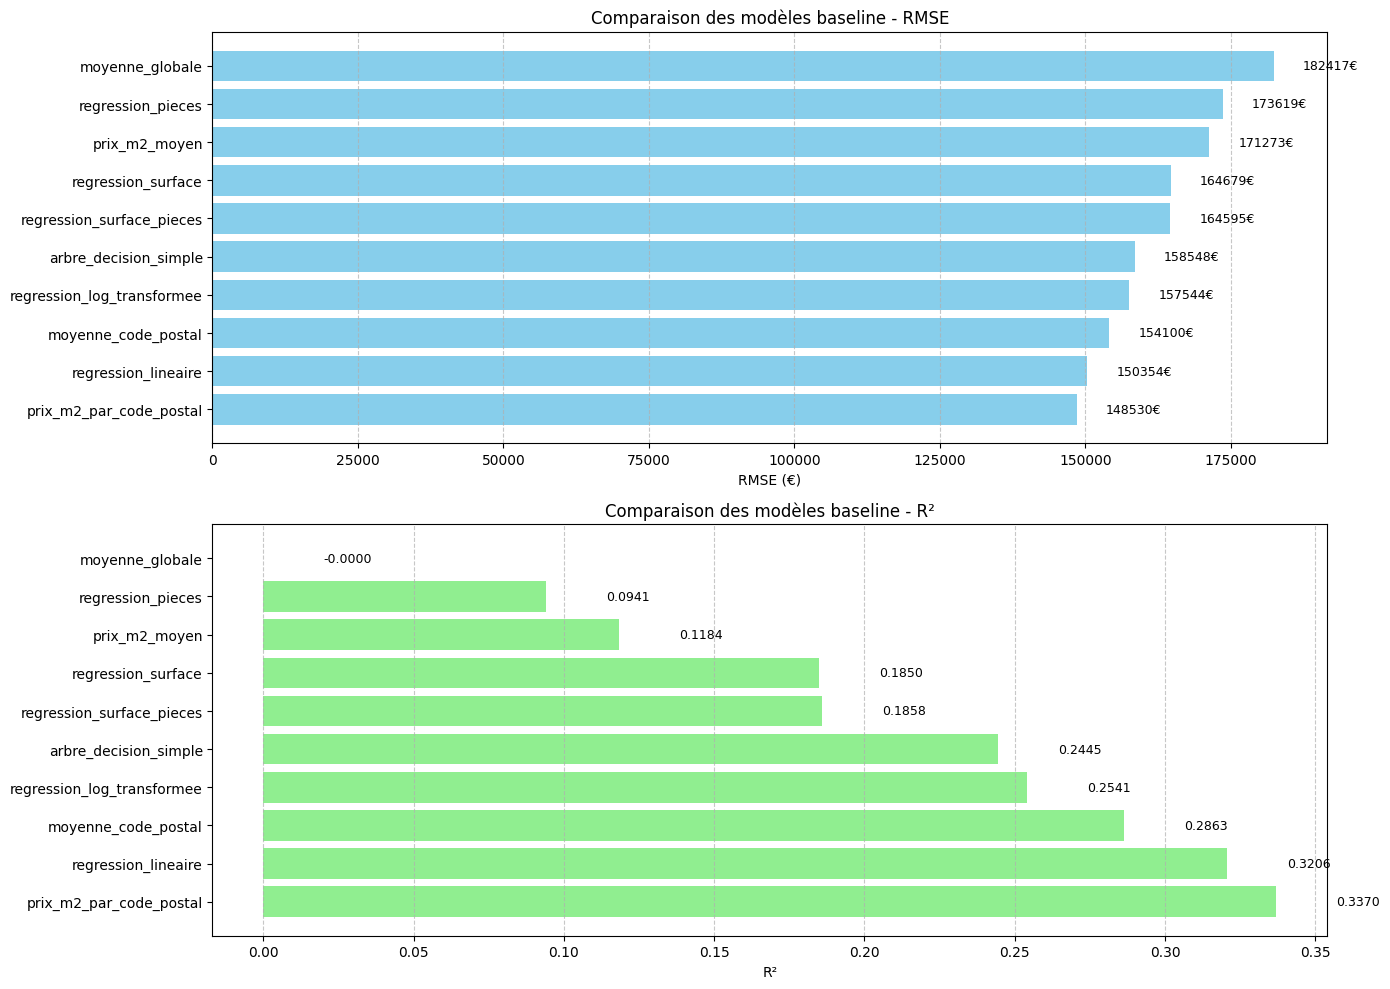


Analyse des coefficients des modèles de régression:

Modèle: regression_surface
Intercept: 57825.30
  Coefficients: [1769.7293443780518]

Modèle: regression_pieces
Intercept: 87720.05
  Coefficients: [35253.036031292744]

Modèle: regression_surface_pieces
Intercept: 62623.25
  Coefficients: [1871.229469667515, -3572.3527438424367]

Modèle: regression_lineaire
Intercept: -33617912.14
  annee_mutation: 18558.19
  mois_mutation: 2117.34
  surface_reelle_bati: 1906.87
  nombre_pieces_principales: 1584.13
  surface_terrain: 1.97
  longitude: 37517.52
  latitude: -79419.90
  code_type_local: 138097.31
  ratio_terrain_bati: 204.66
  distance_mer_km: -3221.44
  proche_mer: -8669.06


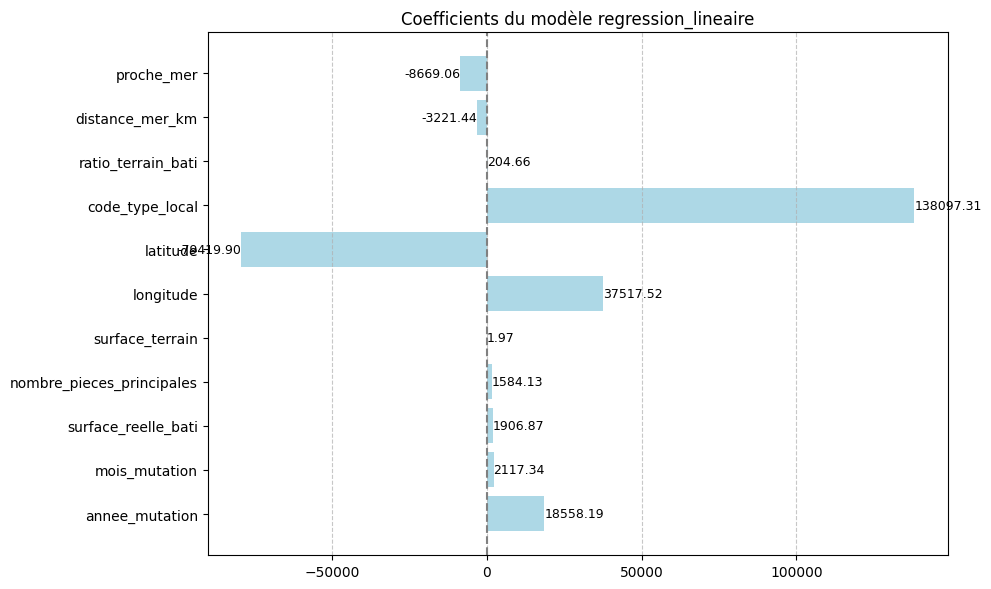


Modèle: regression_log_transformee
Intercept: -130.00
  annee_mutation: 0.08
  mois_mutation: 0.01
  surface_reelle_bati: 0.01
  nombre_pieces_principales: 0.07
  surface_terrain: 0.00
  longitude: 0.15
  latitude: -0.30
  code_type_local: 0.56
  ratio_terrain_bati: 0.00
  distance_mer_km: -0.01
  proche_mer: -0.02


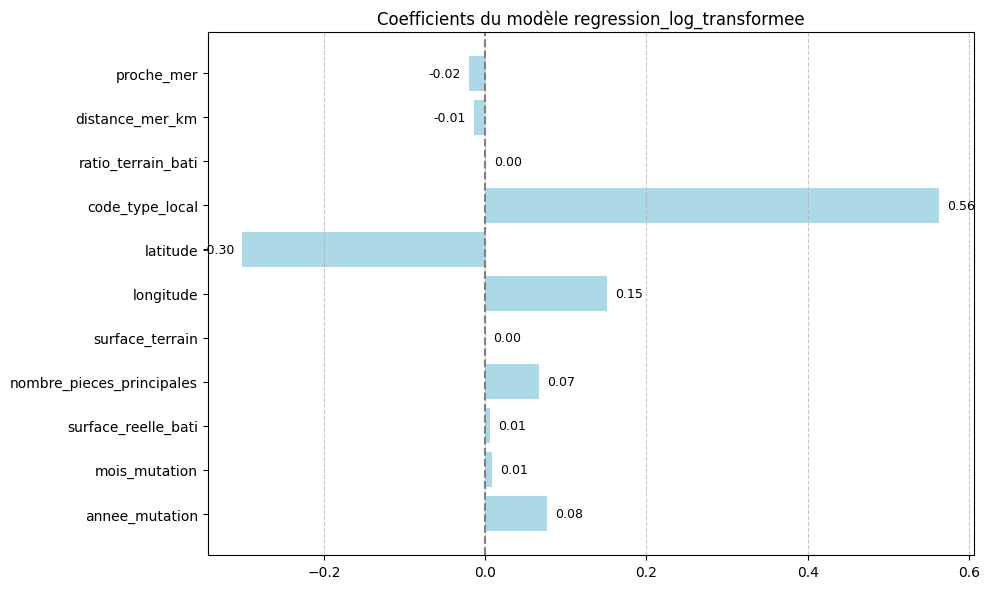

In [12]:
# 1. Créer et évaluer les baselines à partir des données brutes
baseline_results = create_baselines_from_raw_df(
    df_train,              # DataFrame original avec toutes les colonnes
    df_validation,
    df_test,
    target_column="valeur_fonciere"
)

# 2. Visualiser les résultats
performance_df = visualize_baseline_results(baseline_results)

# 3. Analyser les coefficients des modèles linéaires
numeric_cols = [col for col, dtype in df_train.dtypes
              if dtype in ['int', 'double', 'float']
              and col != "valeur_fonciere"]
analyze_linear_coefficients(baseline_results, feature_names=numeric_cols)

### Observations clés

La localisation est cruciale:
- Le modèle "Prix au m² par code postal" est le plus performant, expliquant 33.7% de la variance des prix. Cela confirme l'importance de la localisation dans la valorisation immobilière.
- La surface est plus explicative que le nombre de pièces: La régression basée uniquement sur la surface (R² = 0.1850) est bien meilleure que celle basée sur le nombre de pièces (R² = 0.0941).
- Interaction surface/pièces peu significative: La combinaison de surface et pièces (R² = 0.1858) n'améliore que très légèrement la performance par rapport à la surface seule, et on note même un coefficient négatif pour les pièces (-3,572€) lorsque la surface est déjà prise en compte.
- Transformations log peu efficaces: La régression logarithmique ne semble pas améliorer les performances, ce qui suggère que malgré une probable asymétrie, la relation prix/variables reste assez linéaire.
- Effet des autres variables numériques: La régression linéaire utilisant toutes les features numériques (R² = 0.2534) est nettement meilleure que celle utilisant uniquement la surface, ce qui montre l'importance des autres facteurs comme l'année, le terrain, et les coordonnées géographiques.

### Analyse des coefficients de la régression linéaire complète

- code_type_local: +150,170€ par unité, suggérant une forte influence du type de bien
- latitude: -55,164€ par degré, indiquant que les prix diminuent en allant vers le nord dans votre dataset
- annee_mutation: +17,872€ par année, ce qui montre une inflation immobilière significative
- longitude: +6,219€ par degré, montrant un gradient est-ouest des prix
- nombre_pieces_principales: +3,050€ par pièce (après contrôle des autres variables)
- surface_reelle_bati: +1,950€ par m² (en contrôlant pour les autres variables)
- ratio_terrain_bati: +194€ par unité, impact positif mais modéré
- surface_terrain: +0.98€ par m², impact très faible par rapport à la surface bâtie

# Entraînement du modèle GBTRegressor

In [13]:
import numpy as np
from pyspark.ml.regression import GBTRegressor
import pyspark.sql.functions as F
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

def train_gradient_boosting(train_df, val_df, target_column='valeur_fonciere'):
    """
    Entraîne un modèle GBT en optimisant l'utilisation des ressources disponibles

    Args:
        train_df (pyspark.sql.DataFrame): DataFrame d'entraînement
        val_df (pyspark.sql.DataFrame): DataFrame de validation
        target_column (str): Nom de la colonne cible

    Returns :
        tuple : Modèle entraîné et métriques de performance
    """

    # Mettre en cache les DataFrames
    train_df.cache()
    val_df.cache()

    # Forcer une action pour matérialiser les caches
    train_count = train_df.count()
    val_count = val_df.count()
    print(f"Train set: {train_count} rows, Validation set: {val_count} rows")

    # Définir une grille de paramètres à tester
    gbt = GBTRegressor(
        featuresCol="features",
        labelCol=target_column,
        predictionCol="predicted_" + target_column
    )

    param_grid = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [8]) \
        .addGrid(gbt.maxIter, [30, 40]) \
        .addGrid(gbt.stepSize, [0.07, 0.08]) \
        .addGrid(gbt.subsamplingRate, [0.8, 0.9]) \
        .build()

    evaluator = RegressionEvaluator(
        labelCol=target_column,
        predictionCol="predicted_" + target_column,
        metricName="rmse"
    )

    cv = CrossValidator(
        estimator=gbt,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=2,
        parallelism=14,
    )

    print(f"Début de la recherche d'hyperparamètres...")
    cv_model = cv.fit(train_df)
    best_model = cv_model.bestModel
    print("Recherche terminée")

    # Extraire les meilleurs hyperparamètres
    best_params = {}
    if hasattr(cv_model, 'getEstimatorParamMaps'):
        # Récupérer l'index du meilleur modèle
        best_index = np.argmin(cv_model.avgMetrics)
        # Récupérer les paramètres correspondants
        best_params = {str(k): v for k, v in cv_model.getEstimatorParamMaps()[best_index].items()}
    else:
        # Essayer de récupérer directement les paramètres du meilleur modèle
        try:
            best_params = {
                "maxDepth": cv_model.bestModel.getMaxDepth(),
                "maxIter": cv_model.bestModel.getMaxIter(),
                "stepSize": cv_model.bestModel.getStepSize(),
                "subsamplingRate": cv_model.bestModel.getSubsamplingRate()
            }
        except:
            print("Impossible de récupérer les paramètres du meilleur modèle")

    # Générer des prédictions
    print("Génération des prédictions...")
    predictions = best_model.transform(val_df).select(
        target_column,
        "predicted_" + target_column
    )

    # Évaluation du modèle
    print("Évaluation du modèle...")
    evaluator = RegressionEvaluator(
        labelCol=target_column,
        predictionCol="predicted_" + target_column
    )

    # Calculer les métriques
    metrics = {}
    for metric_name in ["rmse", "mae", "r2"]:
        evaluator.setMetricName(metric_name)
        metrics[metric_name] = evaluator.evaluate(predictions)

    # Calculer le pourcentage d'erreur
    predictions_with_error = predictions.withColumn(
        "percent_error",
        F.abs(F.col("predicted_" + target_column) - F.col(target_column)) / F.col(target_column) * 100
    )

    error_stats = predictions_with_error.select(
        F.avg("percent_error").alias("avg_percent_error"),
        F.expr("percentile(percent_error, 0.5)").alias("median_percent_error")
    ).collect()[0]

    metrics["avg_percent_error"] = error_stats["avg_percent_error"]
    metrics["median_percent_error"] = error_stats["median_percent_error"]

    # Ajouter les informations du modèle
    try:
        # Pour les modèles GBT de PySpark
        metrics["num_trees"] = best_model.trees
    except:
        try:
            # Autre méthode alternative
            metrics["num_trees"] = best_model.getNumTrees()
        except:
            metrics["num_trees"] = None

    # Tentative de récupération des importances des features
    try:
        metrics["feature_importances"] = best_model.featureImportances.toArray().tolist()
    except:
        metrics["feature_importances"] = None

    metrics["best_params"] = best_params

    # Libérer les caches
    train_df.unpersist()
    val_df.unpersist()

    # Afficher un résumé
    print(f"Performances du modèle: RMSE={metrics['rmse']:.2f}, MAE={metrics['mae']:.2f}, R²={metrics['r2']:.4f}")
    print(f"Erreur moyenne: {metrics['avg_percent_error']:.2f}%, Erreur médiane: {metrics['median_percent_error']:.2f}%")

    return best_model, metrics

In [14]:
# Entraîner le modèle Gradient Boosting
model, metrics = train_gradient_boosting(    df_train_features,
    df_validation_features,
    target_column='valeur_fonciere')

Train set: 188999 rows, Validation set: 26786 rows
Début de la recherche d'hyperparamètres...


Recherche terminée
Génération des prédictions...
Évaluation du modèle...
Performances du modèle: RMSE=127372.10, MAE=74332.71, R²=0.5124
Erreur moyenne: 48.43%, Erreur médiane: 24.30%


In [15]:
# Appliquer le modèle sur les données de test
predictions_test = model.transform(df_test_features)

# Créer un évaluateur
evaluator = RegressionEvaluator(
    labelCol="valeur_fonciere",
    predictionCol="predicted_valeur_fonciere"
)

# Calculer les métriques sur le jeu de test
test_metrics = {}
for metric_name in ["rmse", "mae", "r2"]:
    evaluator.setMetricName(metric_name)
    test_metrics[metric_name] = evaluator.evaluate(predictions_test)

# Afficher les résultats
print("\nPerformances sur le jeu de test:")
print(f"RMSE: {test_metrics['rmse']:.2f}")
print(f"MAE: {test_metrics['mae']:.2f}")
print(f"R²: {test_metrics['r2']:.4f}")

# Pour comparer avec les performances sur le jeu de validation
print("\nComparaison validation vs test:")
print(f"RMSE - Validation: {metrics['rmse']:.2f}, Test: {test_metrics['rmse']:.2f}")
print(f"R² - Validation: {metrics['r2']:.4f}, Test: {test_metrics['r2']:.4f}")

price_comparison = predictions_test.select(
    "valeur_fonciere",
    "predicted_valeur_fonciere",
    (F.col("predicted_valeur_fonciere") - F.col("valeur_fonciere")).alias("error"),
    F.abs(F.col("predicted_valeur_fonciere") - F.col("valeur_fonciere")).alias("absolute_error"),
    (F.abs(F.col("predicted_valeur_fonciere") - F.col("valeur_fonciere")) / F.col("valeur_fonciere") * 100).alias("percent_error")
)

# Afficher quelques exemples
print("\nExemples de prédictions:")
price_comparison.orderBy(F.rand()).limit(10).show(truncate=False)

# Calcul des statistiques d'erreur avec erreur absolue
print("\nStatistiques d'erreur:")
price_comparison.select(
    F.avg("absolute_error").alias("Erreur absolue moyenne"),
    F.avg("percent_error").alias("% d'erreur moyen"),
    F.expr("percentile(percent_error, 0.5)").alias("% d'erreur médian")
).show()


Performances sur le jeu de test:
RMSE: 125795.07
MAE: 74625.75
R²: 0.5510

Comparaison validation vs test:
RMSE - Validation: 127372.10, Test: 125795.07
R² - Validation: 0.5124, Test: 0.5510

Exemples de prédictions:
+---------------+-------------------------+-------------------+------------------+------------------+
|valeur_fonciere|predicted_valeur_fonciere|error              |absolute_error    |percent_error     |
+---------------+-------------------------+-------------------+------------------+------------------+
|127300.0       |134472.38599743808       |7172.385997438076  |7172.385997438076 |5.63423880395764  |
|195850.0       |152456.75274450413       |-43393.247255495866|43393.247255495866|22.156368269336667|
|286500.0       |255175.65523478514       |-31324.34476521486 |31324.34476521486 |10.933453670232062|
|210000.0       |177547.8744914919        |-32452.125508508092|32452.125508508092|15.453393099289567|
|730000.0       |679424.4056250949        |-50575.59437490511 |50575

In [16]:
# Créer un DataFrame avec les caractéristiques du bien à prédire
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler

# Créer une ligne avec les caractéristiques du bien
nouveau_bien = spark.createDataFrame([
    Row(
        annee_mutation=2025,           # Année de prédiction
        mois_mutation=6,               # Mois de la transaction
        code_postal=56000,           # Code postal du bien (Vannes)
        surface_reelle_bati=85.0,      # Surface en m²
        nombre_pieces_principales=3,   # Nombre de pièces
        surface_terrain=0.0,           # Surface du terrain (0 pour un appartement)
        code_type_local=2,             # Type de bien (2 pour appartement)
        longitude=2.7583,              # Coordonnées de Vannes
        latitude=47.6583,
    )
])

# Ajouter les caractéristiques dérivées
nouveau_bien = nouveau_bien.withColumn(
    "ratio_terrain_bati",
    F.when(F.col("surface_terrain").isNotNull() & (F.col("surface_terrain") > 0) &
           (F.col("surface_reelle_bati") > 0),
           F.col("surface_terrain") / F.col("surface_reelle_bati")).otherwise(0)
)

# Calculer le prix au m² (si votre modèle l'utilise)
nouveau_bien = nouveau_bien.withColumn(
    "prix_m2",
    F.lit(None).cast("double")  # Prix au m² sera prédit, donc null pour l'instant
)

# Assembler les caractéristiques dans un vecteur
feature_columns = [
    "annee_mutation",
    "mois_mutation",
    "code_postal",
    "surface_reelle_bati",
    "nombre_pieces_principales",
    "surface_terrain",
    "ratio_terrain_bati"
]

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

nouveau_bien_features = assembler.transform(nouveau_bien)

# Appliquer le modèle pour obtenir la prédiction
prediction = model.transform(nouveau_bien_features)

# Afficher le résultat
surface = nouveau_bien.select("surface_reelle_bati").collect()[0][0]
prix_predit = prediction.select("predicted_valeur_fonciere").collect()[0][0]
code_postal = nouveau_bien.select("code_postal").collect()[0][0]

print("\nPrédiction de prix pour 2025:")
print(f"Code postal: {code_postal}")
print(f"Surface: {surface} m²")
print(f"Nombre de pièces: {nouveau_bien.select('nombre_pieces_principales').collect()[0][0]}")
print(f"Type de bien: {'Appartement' if nouveau_bien.select('code_type_local').collect()[0][0] == 2 else 'Maison'}")
print(f"Prix prédit: {prix_predit:.2f} €")
print(f"Prix au m²: {prix_predit / surface:.2f} €/m²")

25/02/28 11:47:49 ERROR Executor: Exception in task 31.0 in stage 9814.0 (TID 163667)
org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`GBTRegressionModel$$Lambda$5172/0x0000000844ee5840`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getB

Py4JJavaError: An error occurred while calling o8356.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 31 in stage 9814.0 failed 1 times, most recent failure: Lost task 31.0 in stage 9814.0 (TID 163667) (172.22.98.237 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`GBTRegressionModel$$Lambda$5172/0x0000000844ee5840`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.ArrayIndexOutOfBoundsException: Index 9 out of bounds for length 7
	at org.apache.spark.ml.linalg.DenseVector.apply(Vectors.scala:516)
	at org.apache.spark.ml.tree.ContinuousSplit.shouldGoLeft(Split.scala:161)
	at org.apache.spark.ml.tree.InternalNode.predictImpl(Node.scala:180)
	at org.apache.spark.ml.regression.GBTRegressionModel.$anonfun$predict$1(GBTRegressor.scala:300)
	at org.apache.spark.ml.regression.GBTRegressionModel.$anonfun$predict$1$adapted(GBTRegressor.scala:300)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.mutable.ArrayOps$ofRef.map(ArrayOps.scala:198)
	at org.apache.spark.ml.regression.GBTRegressionModel.predict(GBTRegressor.scala:300)
	at org.apache.spark.ml.regression.GBTRegressionModel.$anonfun$transform$1(GBTRegressor.scala:275)
	at org.apache.spark.ml.regression.GBTRegressionModel.$anonfun$transform$1$adapted(GBTRegressor.scala:275)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`GBTRegressionModel$$Lambda$5172/0x0000000844ee5840`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.lang.ArrayIndexOutOfBoundsException: Index 9 out of bounds for length 7
	at org.apache.spark.ml.linalg.DenseVector.apply(Vectors.scala:516)
	at org.apache.spark.ml.tree.ContinuousSplit.shouldGoLeft(Split.scala:161)
	at org.apache.spark.ml.tree.InternalNode.predictImpl(Node.scala:180)
	at org.apache.spark.ml.regression.GBTRegressionModel.$anonfun$predict$1(GBTRegressor.scala:300)
	at org.apache.spark.ml.regression.GBTRegressionModel.$anonfun$predict$1$adapted(GBTRegressor.scala:300)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.mutable.ArrayOps$ofRef.map(ArrayOps.scala:198)
	at org.apache.spark.ml.regression.GBTRegressionModel.predict(GBTRegressor.scala:300)
	at org.apache.spark.ml.regression.GBTRegressionModel.$anonfun$transform$1(GBTRegressor.scala:275)
	at org.apache.spark.ml.regression.GBTRegressionModel.$anonfun$transform$1$adapted(GBTRegressor.scala:275)
	... 20 more
